## Modeling Errors and Agreement Attraction in LSTMs

We need to load an older version of pytorch to run this code.

In [ ]:
!pip install torch==1.13.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 905.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 57.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu118
    Uninstalling torch-2.1.0+cu118:
      Successfully uninstalled torch-2.1.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu118 requires torch==2.1.0, but you have torch 1.13.1 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 1.13.1 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 1.13.

Now let's download the LSTM publicly released as a part of Gulordava et al (2018):

In [ ]:
!git clone https://github.com/facebookresearch/colorlessgreenRNNs

%cd /content/colorlessgreenRNNs/src

!wget https://dl.fbaipublicfiles.com/colorless-green-rnns/best-models/English/hidden650_batch128_dropout0.2_lr20.0.pt
!wget -P ../data/lm/English/ https://dl.fbaipublicfiles.com/colorless-green-rnns/training-data/English/train.txt
!wget -P ../data/lm/English/ https://dl.fbaipublicfiles.com/colorless-green-rnns/training-data/English/test.txt
!wget -P ../data/lm/English/ https://dl.fbaipublicfiles.com/colorless-green-rnns/training-data/English/valid.txt
!wget -P ../data/lm/English/ https://dl.fbaipublicfiles.com/colorless-green-rnns/training-data/English/vocab.txt

Cloning into 'colorlessgreenRNNs'...
remote: Enumerating objects: 601, done.
remote: Total 601 (delta 0), reused 0 (delta 0), pack-reused 601
Receiving objects: 100% (601/601), 31.27 MiB | 7.23 MiB/s, done.
Resolving deltas: 100% (321/321), done.
Updating files: 100% (86/86), done.
/content/colorlessgreenRNNs/src
--2023-11-25 18:34:26--  https://dl.fbaipublicfiles.com/colorless-green-rnns/best-models/English/hidden650_batch128_dropout0.2_lr20.0.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.111, 13.226.210.25, 13.226.210.78, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 287304504 (274M) [binary/octet-stream]
Saving to: ‘hidden650_batch128_dropout0.2_lr20.0.pt’

hidden650_batch128_ 100%[===================>] 273.99M  28.5MB/s    in 9.2s    

2023-11-25 18:34:36 (29.7 MB/s) - ‘hidden650_batch128_dropout0.2_lr20.0.pt’ saved [287304504/287304504]

--2023-

And then load that model in

In [ ]:
%cd /content/colorlessgreenRNNs/src/language_models

import torch
import torch.nn as nn
import numpy as np
from model import RNNModel


torch.manual_seed(50360)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(50360)


model_ = None
fn = "../hidden650_batch128_dropout0.2_lr20.0.pt"
with open(fn, "rb") as model_f:
    model_ = torch.load(fn)

# Makes sure your model is loaded onto the GPU (should return true)
next(model_.parameters()).is_cuda

# Construct a new RNNModel using PyTorch 1.x implementations of NN modules
model = RNNModel("LSTM", 50001, 650, 650, 2, 0.2, False)
# Copy over the trained weights from the model loaded in
model.load_state_dict(model_.state_dict())

model = model.cuda()
model.eval()

/content/colorlessgreenRNNs/src/language_models


/usr/local/lib/python3.10/dist-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'model.RNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.10/dist-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.10/dist-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Modul

RNNModel(
  (drop): Dropout(p=0.2, inplace=False)
  (encoder): Embedding(50001, 650)
  (rnn): LSTM(650, 650, num_layers=2, dropout=0.2)
  (decoder): Linear(in_features=650, out_features=50001, bias=True)
)

And set up the `dictionary corpus`


In [ ]:
import dictionary_corpus

data_path = "../../data/lm/English"

dictionary = dictionary_corpus.Dictionary(data_path)

print("Vocab size is ", len(dictionary))

ModuleNotFoundError: ignored

In [ ]:
dictionary.word2idx["horse"], dictionary.word2idx["<unk>"]

(3619, 62)

In [ ]:
gp_example = "the key to the cabinets".split()
print(gp_example)

gp_indices = torch.tensor([dictionary.word2idx[w] if w in dictionary.word2idx
                                  else dictionary.word2idx["<unk>"]
            for w in gp_example], dtype=torch.long).cuda()

print(gp_indices)

Now lets try out a classic example: An agreement attraction prompt (ala Bock & Cutting 1992), using the LM analysis method from Linzen, Dupoux, & Goldberg (2016)

## Revisiting Linzen, Dupoux, & Goldberg (2016)

In [ ]:
# our example sentence, as a list of words (strings)
prompt = "the keys to the cabinet".split()

# map each of the words to an index (<unk> if the word's not in our vocab)
indices = [dictionary.word2idx[w] if w in dictionary.word2idx
                                  else dictionary.word2idx["<unk>"]
           for w in prompt]

indices = torch.tensor(indices, dtype=torch.long)

indices

tensor([   3, 8182,   70,    3, 8254])

In [ ]:
# Run this twice sometimes if you get a cudnn error
indices = indices.cuda()

output, hidden = model(indices.view(-1, 1), # Remember, (sequence_length, batch_size).
                       model.init_hidden(1)) # one input at a time, thus batch_size = 1

In [ ]:
output.size()

torch.Size([5, 1, 50001])

There are a few other things you'll encounter here that are of interest - first, the short snippet converting all the words in the sentence to indices should look a little bit familiar (from the prior session). Another point of interest is the call to `indices.view`, which is our go-to method for changing the shape of pytorch tensors and variables, which you saw briefly in the prior session.

Now let's look at the output of our model

In [ ]:
output.size()

NameError: ignored

The dimensions here are, as one might infer, the length of the sequence (since our input was of length 5), the batch size (since we only fed one input in), and the vocab size (as this is what the length of the vocab was from before!). Thus, for each word in the input sequence, we have the output of the lstm at that point, which is a 50001 dimensional vector  of scores associated with each word in our vocab, just as we saw in the last session. Let's first check out what the most likely next word is based on this model!

Since each output vector at each timestep is a prediction of the next word, we want to get the index of the maximum value (the "most predicted" word) for the output vector corresponding to the last input (the "most predicted" word *after the end of the sequence*). Turning that mess of a sentence into a piece of (hopefully more clear) code, we have

In [ ]:
next_word_scores = output[-1].view(-1) # the output vector corresponding to the last input
max_value, idx = next_word_scores.max(0)
idx = idx.item() # get an int out of a 1x1 tensor. Remove this line to see the difference!

print(idx, dictionary.idx2word[idx])

18 .


That's a, uhh, boring answer. Regardless, what we care about is whether our model knows whether the verb should be singular or plural (to agree with the subject), not whether it knows when to place periods. So let's compare the likelihood of the two possible forms of the verb we want, *is* and *are*

In [ ]:
is_idx = dictionary.word2idx["is"]
are_idx = dictionary.word2idx["are"]

print("is score: ", next_word_scores[is_idx].item())
print("are score: ", next_word_scores[are_idx].item())

NameError: ignored

Note that the raw magnitude of these scores isn't really interpretable. We might want to work with probability distributions instead - that's where softmax comes in!

In [ ]:
import torch.nn.functional as F

next_word_dist = F.softmax(next_word_scores, dim=0)

print("is prob: ", next_word_dist[is_idx].item())
print("are prob: ", next_word_dist[are_idx].item())

NameError: ignored

In [ ]:
import torch.nn.functional as F

prompt = "the paintings which I can see have".split()

indices = [dictionary.word2idx[w] if w in dictionary.word2idx
                                  else dictionary.word2idx["<unk>"]
           for w in prompt]

indices = torch.tensor(indices, dtype=torch.long)

indices = indices.cuda()

output, hidden = model(indices.view(-1, 1), # Remember, (sequence_length, batch_size).
                       model.init_hidden(1)) # one input at a time, thus batch_size = 1

next_word_scores = output[-1].view(-1)
max_value, idx = next_word_scores.max(0)
idx = idx.item()

one_idx = dictionary.word2idx["any"]

next_word_dist = F.softmax(next_word_scores, dim=0)

print("one prob: ", next_word_dist[one_idx].item())

NameError: ignored

In [ ]:
import torch.nn.functional as F

prompt = "none of the paintings which I can see have".split()

indices = [dictionary.word2idx[w] if w in dictionary.word2idx
                                  else dictionary.word2idx["<unk>"]
           for w in prompt]

indices = torch.tensor(indices, dtype=torch.long)

indices = indices.cuda()

output, hidden = model(indices.view(-1, 1), # Remember, (sequence_length, batch_size).
                       model.init_hidden(1)) # one input at a time, thus batch_size = 1

next_word_scores = output[-1].view(-1)
max_value, idx = next_word_scores.max(0)
idx = idx.item()

one_idx = dictionary.word2idx["any"]

next_word_dist = F.softmax(next_word_scores, dim=0)

print("one prob: ", next_word_dist[one_idx].item())

one prob:  0.007696026004850864


In [ ]:
import torch.nn.functional as F

prompt = "the paintings which I cannot see have".split()

indices = [dictionary.word2idx[w] if w in dictionary.word2idx
                                  else dictionary.word2idx["<unk>"]
           for w in prompt]

indices = torch.tensor(indices, dtype=torch.long)

indices = indices.cuda()

output, hidden = model(indices.view(-1, 1), # Remember, (sequence_length, batch_size).
                       model.init_hidden(1)) # one input at a time, thus batch_size = 1

next_word_scores = output[-1].view(-1)
max_value, idx = next_word_scores.max(0)
idx = idx.item()

one_idx = dictionary.word2idx["any"]

next_word_dist = F.softmax(next_word_scores, dim=0)

print("one prob: ", next_word_dist[one_idx].item())

one prob:  0.005277296062558889


In [ ]:
import torch.nn.functional as F

prompt = "none of the paintings which I cannot see have".split()

indices = [dictionary.word2idx[w] if w in dictionary.word2idx
                                  else dictionary.word2idx["<unk>"]
           for w in prompt]

indices = torch.tensor(indices, dtype=torch.long)

indices = indices.cuda()

output, hidden = model(indices.view(-1, 1), # Remember, (sequence_length, batch_size).
                       model.init_hidden(1)) # one input at a time, thus batch_size = 1

next_word_scores = output[-1].view(-1)
max_value, idx = next_word_scores.max(0)
idx = idx.item()

one_idx = dictionary.word2idx["any"]

next_word_dist = F.softmax(next_word_scores, dim=0)

print("one prob: ", next_word_dist[one_idx].item())

one prob:  0.016095349565148354


As a sanity check (I'm going to put myself out there yet again and make a claim about what your results should be), you should be seeing that the score/prob for *are* is greater than the score/prob for *is* - the model is not being fooled by the attractor!

But are we done? Is this all we need to do?

Of course not!

When we run psycholinguistic experiments on humans, we don't give them one trial and call it a day - we run experiments with many, many items to control for item effects (e.g., did the specific words we use bias the results? Specific combinations of words?) and just for the reliability of the effect (e.g. did the participant guess and get lucky? or do they actually reliably show this effect?). Both of those concerns are still live when working with computational models instead of people (with the first being slightly more important than the second, since we can actually look at relative probs with the model).

So what we need to do is come up with a set of test examples, and see what the model does for a larger set of test sentences. Luckily, we can borrow some from [Linzen & Leonard (2018)](https://arxiv.org/pdf/1807.06882.pdf).

In [ ]:
!wget https://raw.githubusercontent.com/jhupsycholing/RNNvsHumanSyntax/master/charts/pprc.csv

--2023-11-25 18:39:19--  https://raw.githubusercontent.com/jhupsycholing/RNNvsHumanSyntax/master/charts/pprc.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1110070 (1.1M) [text/plain]
Saving to: ‘pprc.csv’

pprc.csv            100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2023-11-25 18:39:20 (27.8 MB/s) - ‘pprc.csv’ saved [1110070/1110070]



In [ ]:
import pandas as pd

data = pd.read_csv("pprc.csv")[["item_id", "condition", "sentence", "expected"]].drop_duplicates()

data

,item_id,condition,sentence,expected
0,0,prep_ss,the demo tape from the popular rock singer,VBZ
1,0,prep_sp,the demo tape from the popular rock singers,VBZ
2,0,prep_ps,the demo tapes from the popular rock singer,VBP
3,0,prep_pp,the demo tapes from the popular rock singers,VBP
4,0,rel_ss,the demo tape that promoted the rock singer,VBZ
...,...,...,...,...
251,31,prep_pp,the rulers of the roman city - states,VBP
252,31,rel_ss,the ruler who enslaved the city - state,VBZ
253,31,rel_sp,the ruler who enslaved the city - states,VBZ
254,31,rel_ps,the rulers who enslaved the city - state,VBP


Now we have a nice little dataset of prompts with varying kinds of attractors: 32 frames, either a relative clause attractor or a prepositional phrase, singular or plural subjects, with attractors either matching the subject's number or not. That's 32 * 2 * 2 * 2 = 256 different sentences!

1. **write a test function that takes in the parameters marked below and adds 2 columns to the dataframe: "predicted", which contains (as either "is" or "are") which of the two words is deemed more likely by the model, and "correct", which is 1 if the model picked right and 0 if it picked wrong"**

2. **write get_accs function that takes the parameters marked below and builds a dictionary with the model's accuracy on each condition**

You won't need to do too much fancy stuff with pandas - just take a look at the examples in the following two fields below and you'll see all of the tools you need to see.

In [ ]:
expected = data["expected"] # you can treat this sequence just like a list

# just run a list comprehension on it here for style, loops work too
target = [("is" if pos == "VBZ" else "are")
          for pos in expected]

# make a new column just like a new entry in a dictionary
data["target"] = target

# or note that you can also do something like

lengths = []
for sentence in data["sentence"]:
  lengths.append(len(sentence.split()))

data["num_words"] = lengths

data


,item_id,condition,sentence,expected,target,num_words
0,0,prep_ss,the demo tape from the popular rock singer,VBZ,is,8
1,0,prep_sp,the demo tape from the popular rock singers,VBZ,is,8
2,0,prep_ps,the demo tapes from the popular rock singer,VBP,are,8
3,0,prep_pp,the demo tapes from the popular rock singers,VBP,are,8
4,0,rel_ss,the demo tape that promoted the rock singer,VBZ,is,8
...,...,...,...,...,...,...
251,31,prep_pp,the rulers of the roman city - states,VBP,are,8
252,31,rel_ss,the ruler who enslaved the city - state,VBZ,is,8
253,31,rel_sp,the ruler who enslaved the city - states,VBZ,is,8
254,31,rel_ps,the rulers who enslaved the city - state,VBP,are,8


In [ ]:
# For each unique condition in the conditions column
conditions = set(data["condition"])
for condition in conditions:
  # Extract all rows of data where the condition is the one we want
  cond_rows = data[data["condition"] == condition]

  # Get the mean of the num_words column of those rows
  mean_len = cond_rows["num_words"].mean()

  # Print it out
  print("mean length for {}: {}".format(condition, mean_len))

# Hey, they're all perfectly balanced, as all well designed experimental stimuli should be

mean length for prep_pp: 6.84375
mean length for prep_ss: 6.84375
mean length for rel_ps: 6.84375
mean length for rel_pp: 6.84375
mean length for rel_ss: 6.84375
mean length for prep_sp: 6.84375
mean length for rel_sp: 6.84375
mean length for prep_ps: 6.84375


In [ ]:
def test(model, data):
  data["prediction"] = None
  data["correct"] = None

  model.eval()

  # Loop through data
  for index, row in data.iterrows():
    sentence = row["sentence"]  # Get the sentence from the current row

    # convert sentence to indices
    prompt = sentence.split()

    indices = [dictionary.word2idx[w] if w in dictionary.word2idx
               else dictionary.word2idx["<unk>"] for w in prompt]

    indices = torch.tensor(indices, dtype=torch.long)

    # move to GPU
    indices = indices.cuda()

    # run model on sentence
    output, hidden = model(indices.view(-1, 1), model.init_hidden(1))

    next_word_scores = output[-1].view(-1) # the output vector corresponding to the last input
    #max_value, idx = next_word_scores.max(0)
    #idx = idx.item() # get an int out of a 1x1 tensor. Remove this line to see the difference!

    # compare is and are's scores
    is_idx = dictionary.word2idx["is"]
    are_idx = dictionary.word2idx["are"]

    next_word_dist = F.softmax(next_word_scores, dim=0)
    is_are_prob = next_word_dist[is_idx].item(), next_word_dist[are_idx].item()

    data.at[index, "prediction"] = "is" if (is_are_prob[0] >= is_are_prob[1]) else "are"
    data.at[index, "correct"] = 1 if data.at[index, "prediction"] == data.at[index, "target"] else 0

test(model, data)

data

NameError: ignored

In [ ]:
def get_accs(data):
  if "correct" not in data:
    print("Run test to get the model predictions (or make sure your test is working!)")

  accs = {}
  conditions = data["condition"].unique()

  for cond in conditions:
      restriction = data[data["condition"] == cond]
      if len(restriction) > 0:
          total_correct = sum(restriction["correct"])
          accs[cond] = total_correct / len(restriction)
      else:
          accs[cond] = 0.0

  return accs

accs = get_accs(data)

for condition,acc in accs.items():
  print("{}: {:.4}%".format(condition, acc))

prep_ss: 1.0%
prep_sp: 0.3125%
prep_ps: 0.5312%
prep_pp: 0.9688%
rel_ss: 1.0%
rel_sp: 0.1562%
rel_ps: 0.7188%
rel_pp: 0.9688%


And there we have it! Are there differences across structures/subject numbers? where do models do the best (and worst)?

We won't dive too deep into this dataset, but feel free to mess around with the dataset yourself if you're interested!

### It's your turn!

Now that you've worked through this notebook, you've seen one way to test the knowledge of language in a network language models. Using your new-found expertise, it's now time to strike out on your own and use the Gulordova LSTM to test a hypothesis of your own. You are also (very) welcome to use one of the LSTMs that Gulordova et al. trained for Italian, Hebrew and Russian, if you prefer. You can download them from the links given on the bottom of the page at https://github.com/facebookresearch/colorlessgreenRNNs/tree/main/data (if you hover over the relevant link, you can see the path for the model, and you can use that path to modify the line above where we downloaded the English model). You will need to choose some phenomenon, create a set of example sentences with correct answers, evaluate model performance and report the results.

To get yourself oriented, try to determine:

1. What are the relevant properties of the phenomenon you're concerned with, and what is the question you are trying to ask?

2. What type of example sentences will allow you to probe knowledge of this phenomenon?

3. What is the "right" (human) answer in each case?

4. How will you evaluate the model's output (you may be comparing two specific probabilities, the sum of a number of probabilities,  or something else entirely, depending on the phenomenon). Make sure you keep this in mind when designing your stimuli!

5. How do the model's results bear on your question? Do the results say something about the model, or about human cognition?

Feel free to ask questions and discuss!

In [ ]:
%cd /content/NPI_test_data

/content/NPI_test_data


In [ ]:
my_data = pd.read_csv("my_data.csv")[["number", "construction", "sentence", "item", "grammaticality"]].drop_duplicates()

my_data

,number,construction,sentence,item,grammaticality
0,0,p_pn,the laws have done,any,0
1,1,p_pn,many of the laws have done,any,0
2,2,p_pn,it is the case that the laws have done,any,0
3,3,p_prel,the laws which I have studied have done,any,0
4,4,p_prel,many of the laws which I have studied have done,any,0
...,...,...,...,...,...
1975,1975,n_nrel,none of the passengers which I have not have s...,any,1
1976,1976,n_nrel,it is not the case that the passengers which I...,any,1
1977,1977,n_npp,no passengers in none of these places impress,any,1
1978,1978,n_npp,none of the passengers in none of these places...,any,1


In [ ]:
%cd /content/colorlessgreenRNNs/src

/content/colorlessgreenRNNs/src


In [ ]:
lengths = []
for sentence in my_data["sentence"]:
  lengths.append(len(sentence.split()))

my_data["num_words"] = lengths

my_data

,number,construction,sentence,item,grammaticality,num_words
0,0,p_pn,the laws have done,any,0,4
1,1,p_pn,many of the laws have done,any,0,6
2,2,p_pn,it is the case that the laws have done,any,0,9
3,3,p_prel,the laws which I have studied have done,any,0,8
4,4,p_prel,many of the laws which I have studied have done,any,0,10
...,...,...,...,...,...,...
1975,1975,n_nrel,none of the passengers which I have not have s...,any,1,11
1976,1976,n_nrel,it is not the case that the passengers which I...,any,1,14
1977,1977,n_npp,no passengers in none of these places impress,any,1,8
1978,1978,n_npp,none of the passengers in none of these places...,any,1,10


In [ ]:
constructions = set(my_data["construction"])
for construction in constructions:
  construct_rows = my_data[my_data["construction"] == construction]
  mean_len = construct_rows["num_words"].mean()
  print("mean length for {}: {}".format(construction, mean_len))

mean length for n_pn: 6.166666666666667
mean length for n_nrel: 11.5
mean length for p_ppp: 8.833333333333334
mean length for p_prel: 9.5
mean length for n_ppp: 8.833333333333334
mean length for n_npp: 10.833333333333334
mean length for p_pn: 5.833333333333333
mean length for p_npp: 10.5
mean length for n_prel: 10.166666666666666
mean length for p_nrel: 10.833333333333334


In [ ]:
def my_test(model, my_data):
  my_data["prob"] = None

  model.eval()

  # Loop through data
  for index, row in my_data.iterrows():
    sentence = row["sentence"]  # Get the sentence from the current row

    # convert sentence to indices
    prompt = sentence.split()

    indices = [dictionary.word2idx[w] if w in dictionary.word2idx
               else dictionary.word2idx["<unk>"] for w in prompt]

    indices = torch.tensor(indices, dtype=torch.long)

    # move to GPU
    indices = indices.cuda()

    # run model on sentence
    output, hidden = model(indices.view(-1, 1), model.init_hidden(1))

    next_word_scores = output[-1].view(-1) # the output vector corresponding to the last input
    #max_value, idx = next_word_scores.max(0)
    #idx = idx.item() # get an int out of a 1x1 tensor. Remove this line to see the difference!

    # compare is and are's scores
    item_idx = dictionary.word2idx[row["item"]]

    next_word_dist = F.softmax(next_word_scores, dim=0)
    item_prob = next_word_dist[item_idx].item()

    my_data.at[index, "prob"] = item_prob

my_test(model, my_data)

my_data

,number,construction,sentence,item,grammaticality,num_words,prob
0,0,p_pn,the laws have done,any,0,4,0.007717
1,1,p_pn,many of the laws have done,any,0,6,0.00452
2,2,p_pn,it is the case that the laws have done,any,0,9,0.010803
3,3,p_prel,the laws which I have studied have done,any,0,8,0.002539
4,4,p_prel,many of the laws which I have studied have done,any,0,10,0.001796
...,...,...,...,...,...,...,...
1975,1975,n_nrel,none of the passengers which I have not have s...,any,1,11,0.006637
1976,1976,n_nrel,it is not the case that the passengers which I...,any,1,14,0.005305
1977,1977,n_npp,no passengers in none of these places impress,any,1,8,0.008328
1978,1978,n_npp,none of the passengers in none of these places...,any,1,10,0.009595


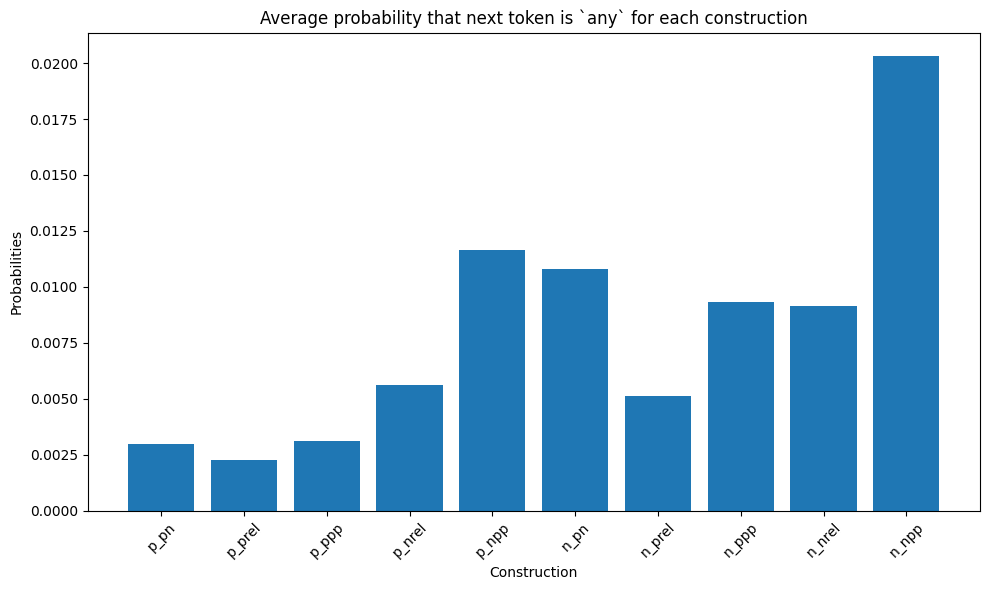

p_pn: 0.002984%
p_prel: 0.002279%
p_ppp: 0.003114%
p_nrel: 0.005624%
p_npp: 0.01165%
n_pn: 0.0108%
n_prel: 0.005125%
n_ppp: 0.009302%
n_nrel: 0.009142%
n_npp: 0.02033%


In [ ]:
def my_get_accs(my_data):
  if "prob" not in my_data:
    print("Run test to get the model predictions (or make sure your test is working!)")

  accs = {}
  constructions = my_data["construction"].unique()

  for construct in constructions:
      restriction = my_data[my_data["construction"] == construct]
      if len(restriction) > 0:
          total_prob = sum(restriction["prob"])
          accs[construct] = total_prob / len(restriction)
      else:
          accs[construct] = 0.0

  return accs

my_accs = my_get_accs(my_data)

df = pd.DataFrame(list(my_accs.items()), columns=['Keys', 'Values'])

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(df['Keys'], df['Values'])
plt.xlabel('Construction')
plt.ylabel('Probabilities')
plt.title('Average probability that next token is `any` for each construction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

for construction,my_acc in my_accs.items():
  print("{}: {:.4}%".format(construction, my_acc))

In [ ]:
file_path = "results.csv"

# Use the to_csv method to save the DataFrame to a CSV file
my_data.to_csv(file_path, index=False)

NameError: ignored

In [ ]:
!pwd

/content/colorlessgreenRNNs/src
